# STM Transit Delay Data Modeling

This notebook explores three tree-based regression models in order to find the one that predicts the delay with the best accuracy.

## Imports

In [34]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, VotingRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV, RandomizedSearchCV
from xgboost import XGBRegressor

In [2]:
df = pd.read_csv('../data/preprocessed.csv')

## Split the data

In [3]:
# Separate the features from the target variable
X = df.drop('delay', axis=1)
y = df['delay']

In [4]:
# Train-validation-test split (70-15-15) 
# Use 70% for training because the dataset is large
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

Since only tree-based regression models are explored in this project, scaling is not needed because the models are not sensitive to the absolute scale or distribution of the features.

## First Model: Random Forest Regression

### Find optimal number of trees

In [5]:
# Initialize model with warm start
base_model = RandomForestRegressor(
  n_estimators=10,
  warm_start=True, # allow adding more trees without resetting
  random_state=42,
  n_jobs=-1
)

In [7]:
# Combine warm start with manual early stopping
errors = []
n_estimators_range = range(10, 610, 10)
best_rmse = float('inf')
best_n = 10

for n in n_estimators_range:
    base_model.n_estimators = n
    base_model.fit(X_train, y_train)  # keep training, adding 10 more trees each time
    preds = base_model.predict(X_val)
    rmse = root_mean_squared_error(y_val, preds)
    errors.append(rmse)
    
    if rmse < best_rmse:
        best_rmse = rmse
        best_n = n

print(f'Best number of trees: {best_n} with RMSE: {best_rmse:.4f}')

/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


Best number of trees: 570 with RMSE: 110.0719


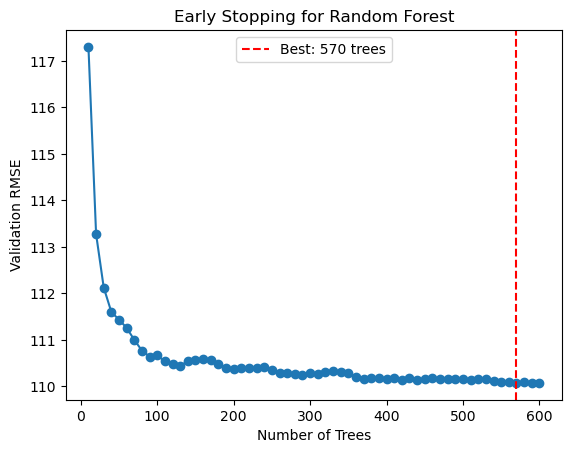

In [8]:
# Plot the curve
plt.plot(n_estimators_range, errors, marker='o')
plt.axvline(x=best_n, color='r', linestyle='--', label=f'Best: {best_n} trees')
plt.xlabel('Number of Trees')
plt.ylabel('Validation RMSE')
plt.title('Early Stopping for Random Forest')
plt.legend()
plt.show()

### Fit Base Model

In [ ]:
# Use optimal number of trees
base_rf = RandomForestRegressor(n_estimators=best_n, random_state=42)
base_rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=570, random_state=42)

### Evaluate Model

#### Metrics

In [ ]:
y_pred = base_rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

MAE: 67.86
RMSE: 110.07
R²: 0.2089


**MAE**<br>
On average, the predictions are off by one minute, which seems reasonable.

**RMSE**<br>
The typical error being about 2 minutes seems pretty good.

**R²**<br>
The model explains 48% of the variance in the actual delays, which is not too bad, considering how noisy and random transit delays can be (weather, mechanical issues, accidents, etc.)

#### Residual Analysis

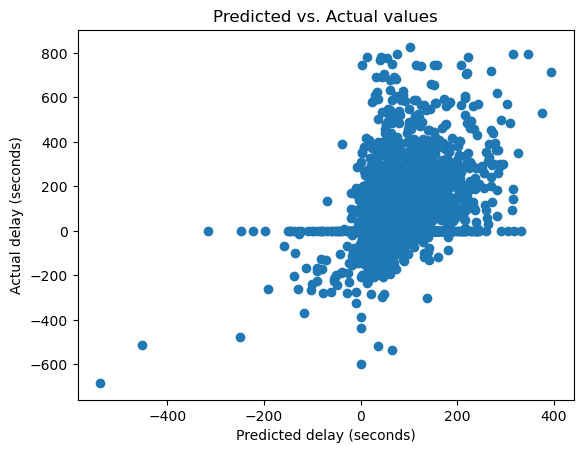

In [11]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.savefig('../images/actual_vs_predict_base.png', bbox_inches='tight')
plt.show()

Interpret plot

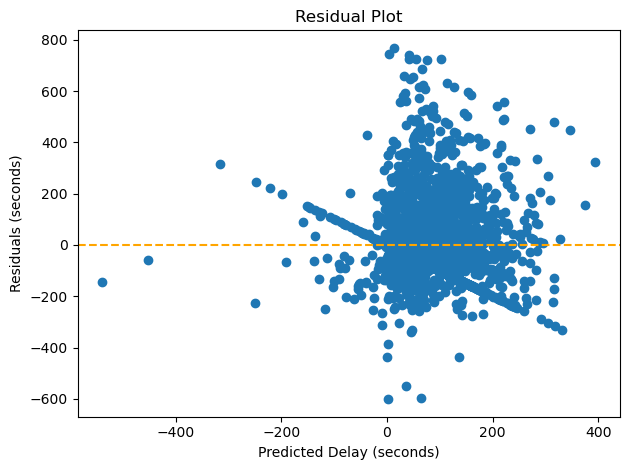

In [12]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_base.png', bbox_inches='tight')
plt.show()

Interpret plot

#### K-Fold Cross Validation

In [ ]:
scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'RMSE': make_scorer(root_mean_squared_error, greater_is_better=False),
    'R²': make_scorer(r2_score)
}

scores = cross_validate(
  base_rf,
  X_train,
  y_train,
  scoring=scoring,
  cv=5,
  n_jobs=-1)

scores_df = pd.DataFrame(scores)

In [14]:
print(f'Mean MAE: {-scores_df['test_MAE'].mean()}')
print(f'Mean RMSE: {-scores_df['test_RMSE'].mean()}')
print(f'Mean R²: {scores_df['test_R²'].mean()}')

Mean MAE: 71.0385219969539
Mean RMSE: 115.40715522666207
Mean R²: 0.19001597380036736


### Hyperparameter tuning

In [19]:
# Run a Randomized Search instead of a GridSearch due to the large volume of data
param_grid = {
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  estimator=RandomForestRegressor(n_estimators=best_n, random_state=42),
  param_distributions=param_grid,
  scoring='neg_root_mean_squared_error',
  n_iter=10,
  cv=5,
  n_jobs=-1,
  random_state=42
)

random_model.fit(X_train, y_train)

RandomizedSearchCV(estimator=RandomForestRegressor(n_estimators=570,
                                                   random_state=42),
                   n_jobs=-1,
                   param_distributions={'max_depth': [None, 10, 20],
                                        'max_features': ['sqrt', 'log2', 0.8],
                                        'max_leaf_nodes': [None, 50, 100],
                                        'min_samples_leaf': [1, 2, 5, 10],
                                        'min_samples_split': [2, 5, 10, 20]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [23]:
# Fit model with best parameters
best_params = random_model.best_params_

final_rf = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, max_features=0.8, min_samples_leaf=5,
                      n_estimators=570, n_jobs=-1, random_state=42)

In [24]:
# Evaluate model
y_pred = final_rf.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

MAE: 67.02
RMSE: 110.57
R²: 0.2017


### Feature Importances

In [25]:
importances = base_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in base_model.estimators_], axis=0)

In [26]:
# Sort predictors
feature_importances = pd.Series(importances, index=X.columns)
feature_importances = feature_importances.sort_values(ascending=False)
feature_importances

vehicle_id                   0.140690
stop_sequence                0.099533
stop_lat                     0.097040
stop_id                      0.095753
stop_lon                     0.091303
trip_progress                0.084900
route_id                     0.080368
sch_hour_sin                 0.051869
sch_hour_cos                 0.042954
hour_sin                     0.042781
windspeed                    0.034918
hour_cos                     0.032779
occupancy_status             0.030837
temperature                  0.026296
nearest_incident_distance    0.009832
is_peak_hour                 0.009431
incident_delay               0.008561
wheelchair_boarding          0.004646
weather_Overcast             0.004146
incident_delay_magnitude     0.002497
incident_nearby              0.002099
sch_day_sin                  0.001422
sch_day_cos                  0.001327
day_cos                      0.001074
day_sin                      0.001038
is_weekend                   0.000985
incident_Roa

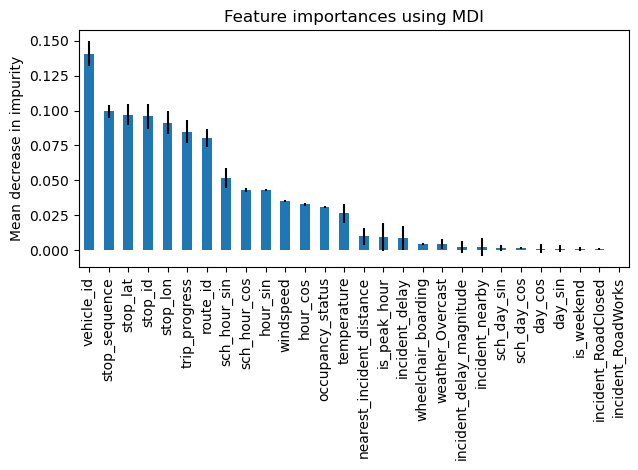

In [27]:
# Plot the impurity-based importance (MDI)
fig, ax = plt.subplots()
feature_importances.plot.bar(yerr=std, ax=ax)
ax.set_title('Feature importances using MDI')
ax.set_ylabel('Mean decrease in impurity')
fig.tight_layout()
plt.savefig('../images/mdi_rf.png', bbox_inches='tight')
plt.show()

Interpret plot

### Recursive Feature Elimination (RFE)

In [28]:
rfe_list = []
X_current = X.copy()
X_train_current = X_train.copy()
X_val_current = X_val.copy()
X_test_current = X_test.copy()
best_rmse = float('inf')
best_features = X_train_current.columns.tolist()

keep_going = True

while keep_going and len(X_current.columns) > 5: # keep at least 5 features
	# Fit model
	rf = RandomForestRegressor(
		n_estimators=best_n,
		random_state=42,
		n_jobs=-1
	)

	nb_features = len(X_current.columns)

	rf.fit(X_train_current, y_train)

	# Predict and calculate RMSE
	y_pred = rf.predict(X_val_current)
	rmse = root_mean_squared_error(y_val, y_pred)

	rfe_list.append({
		'nb_features': nb_features,
		'rmse': rmse
	})

	# Feature importance
	importances = pd.Series(rf.feature_importances_, index=X_current.columns)
	weakest_feature = importances.idxmin()

	print(f'RMSE: {rmse:.4f} | Dropping: {weakest_feature} (importance {importances.min():.6f})')

	if rmse <= best_rmse:
		best_rmse = rmse
		best_features = X_current.columns.tolist()

		# Drop the weakest feature
		X_current = X_current.drop(columns=[weakest_feature], axis=1)
		X_train_current = X_train_current.drop(columns=[weakest_feature], axis=1)
		X_val_current = X_val_current.drop(columns=[weakest_feature], axis=1)
		X_test_current = X_test_current.drop(columns=[weakest_feature], axis=1)
	else:
		# If performance gets worse, stop
		print('Performance worsened. Stopping feature elimination.')
		keep_going = False

rfe_df = pd.DataFrame(rfe_list)
print("\nBest set of features found:")
print(best_features)
print(f"Final validation RMSE: {best_rmse:.4f}")

RMSE: 110.0719 | Dropping: incident_RoadWorks (importance 0.000042)
RMSE: 110.1735 | Dropping: incident_RoadClosed (importance 0.000851)
Performance worsened. Stopping feature elimination.

Best set of features found:
['vehicle_id', 'occupancy_status', 'route_id', 'stop_id', 'stop_lat', 'stop_lon', 'stop_sequence', 'trip_progress', 'wheelchair_boarding', 'day_sin', 'day_cos', 'sch_day_sin', 'sch_day_cos', 'hour_sin', 'hour_cos', 'sch_hour_sin', 'sch_hour_cos', 'is_weekend', 'is_peak_hour', 'temperature', 'windspeed', 'weather_Overcast', 'incident_nearby', 'nearest_incident_distance', 'incident_delay', 'incident_delay_magnitude', 'incident_RoadClosed', 'incident_RoadWorks']
Final validation RMSE: 110.0719


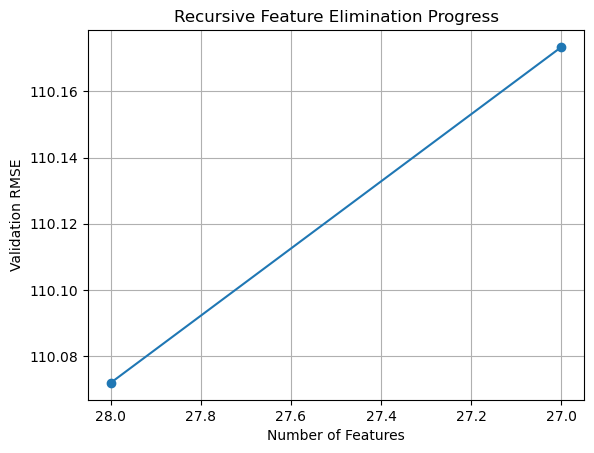

In [33]:
# Plot RSME at each step
plt.plot(rfe_df['nb_features'], rfe_df['rmse'], marker='o')
plt.gca().invert_xaxis() # More features on the left
plt.xlabel('Number of Features')
plt.ylabel('Validation RMSE')
plt.title('Recursive Feature Elimination Progress')
plt.grid(True)
plt.savefig('../images/rfe_rmse.png', bbox_inches='tight')
plt.show()

In [36]:
# Retrain model on reduced features
final_rf_retrained = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_samples_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

final_rf_retrained.fit(X_train_current, y_train)

RandomForestRegressor(max_depth=20, max_features=0.8, min_samples_leaf=5,
                      n_estimators=570, n_jobs=-1, random_state=42)

In [37]:
# Evaluate model
y_pred = final_rf_retrained.predict(X_val_current)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

MAE: 67.09
RMSE: 110.61
R²: 0.2011


### Retune Parameters

In [ ]:
param_grid = {
	'n_estimators': [300, 400, 500, 600],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
	'max_leaf_nodes': [None, 50, 100],
	'max_depth': [None, 10, 20],
  	'max_features': ['sqrt', 'log2', 0.8],
}

random_model = RandomizedSearchCV(
  estimator=RandomForestRegressor(random_state=42),
  param_distributions=param_grid,
  scoring='neg_root_mean_squared_error',
  n_iter=5,
  cv=5,
  n_jobs=-1,
  random_state=42
)

random_model.fit(X_train_current, y_train)

In [ ]:
# Evaluate model
y_pred = final_rf_retrained.predict(X_val_current)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.4f}')

In [ ]:
# Retrain model on reduced features
best_params = random_model.best_params_

final_rf_retrained_cv = RandomForestRegressor(
  	n_estimators=best_n,
  	min_samples_split=best_params['min_sample_split'],
  	min_samples_leaf=best_params['min_samples_leaf'],
  	max_leaf_nodes=best_params['max_leaf_nodes'],
  	max_depth=best_params['max_depth'],
  	max_features=best_params['max_features'],
  	random_state=42,
    n_jobs=-1
)

final_rf_retrained_cv.fit(X_train_current, y_train)

### Revalidate Model

In [ ]:
# Evaluate metrics
y_pred = final_rf_retrained_cv.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

In [ ]:
# Plot predicted vs. actual values
plt.scatter(x=y_pred, y=y_val)
plt.title('Final Model Predicted vs. Actual values')
plt.xlabel('Predicted delay (seconds)')
plt.ylabel('Actual delay (seconds)')
plt.savefig('../images/actual_vs_predict_final.png', bbox_inches='tight')
plt.show()

Interpret plot

In [ ]:
# Plot residuals
residuals = y_val - y_pred
    
plt.scatter(x=y_pred, y=residuals)
plt.title('Final Model Residual Plot')
plt.xlabel('Predicted Delay (seconds)')
plt.ylabel('Residuals (seconds)')
plt.axhline(0, linestyle='--', color='orange')
plt.tight_layout()
plt.savefig('../images/residual_plot_final.png', bbox_inches='tight')
plt.show()

Interpret plot

In [ ]:
# Save best parameters and features
rf_best = {
	'best_params': best_params,
  	'best_features': best_features,
}

with open('../models/rf_best_params.pkl', 'wb') as handle:
	pickle.dump(rf_best, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# Save model
joblib.dump(final_rf_retrained_cv, '../models/random_forest_model.pkl')

## Second Model: Random Forest + Gradient Boosting (Model ensembling)

## Third Model: XGBoost

## Final Model

### Evaluation

### Make Prediction

## End